In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotnine as pn

In [28]:
def import_vsweep(fpath="schematic/data/dac7_L0.15W1vout-", num=2):
    list_df = []
    list_perchange = []
    for i in range(num):
        df_tmp = pd.read_csv(fpath+str(i+1)+".txt", delimiter="\s+")

        # Turn bits into binary
        df_tmp["v(b0)"] = (df_tmp["v(b0)"] > 1e-3).astype(float)
        df_tmp["v(b1)"] = (df_tmp["v(b1)"] > 1e-3).astype(float)
        df_tmp["v(b2)"] = (df_tmp["v(b2)"] > 1e-3).astype(float)
        df_tmp["v(b3)"] = (df_tmp["v(b3)"] > 1e-3).astype(float)
        df_tmp["v(b4)"] = (df_tmp["v(b4)"] > 1e-3).astype(float)
        df_tmp["v(b5)"] = (df_tmp["v(b5)"] > 1e-3).astype(float)
        df_tmp["v(b6)"] = (df_tmp["v(b6)"] > 1e-3).astype(float)
        df_tmp["src"] = np.ones(len(df_tmp.iloc[:, [1]]))*i
        df_tmp["lsb"] = df_tmp["i(vbias)"]/96
        
        # Calculate Percent change at 80%
        percent80 = df_tmp[df_tmp["v-sweep"]==1.44]
        percent0 = df_tmp[df_tmp["v-sweep"]==0]
        per_change = (percent80["i(viout)"].values - percent0["i(viout)"].values)/percent0["i(viout)"].values/(percent80["v-sweep"].values - percent0["v-sweep"].values)
        list_perchange.append(per_change)
        
        df_tmp["diff"] = np.array([df_tmp.lsb.iloc[0]]+list(df_tmp["i(viout)"].iloc[1:].values - df_tmp["i(viout)"].iloc[0:-1].values))
    #     df_tmp["inl"] = df_tmp["dnl"].cumsum()
        list_df.append(df_tmp)
    return pd.concat(list_df).reset_index(drop=True), np.array(list_perchange)*100

In [24]:
my_df, my_per = import_vsweep(fpath="schematic/data/dac7my_L1W3vdd-", num=2)
my_df["src"] = my_df["src"].astype("str")
my_df.head()

,v-sweep,v(b0),v(b1),v(b2),v(b3),v(b4),v(b5),v(b6),i(vbias),i(viout),v(vout),src,lsb,diff
0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.496802e-34,-0.002618,1.0,0.0,9.892502e-36,9.892502e-36
1,0.01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.085339e-15,-0.002286,1.0,0.0,8.422228e-17,3.319396e-04
2,0.02,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.608230e-14,-0.001977,1.0,0.0,1.675239e-16,3.094221e-04
3,0.03,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.403541e-14,-0.001691,1.0,0.0,2.503688e-16,2.854108e-04
4,0.04,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.196329e-14,-0.001431,1.0,0.0,3.329509e-16,2.600854e-04


In [25]:
my_per

array([], dtype=float64)

Text(0, 0.5, 'DNL (LSB)')

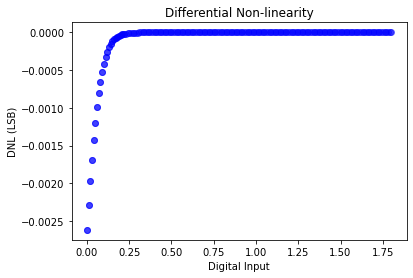

In [26]:
fig, ax = plt.subplots()
ax.plot(my_df["v-sweep"], my_df["i(viout)"], "bo", alpha=0.5)
ax.set_title("Differential Non-linearity")
ax.set_xlabel("Digital Input")
ax.set_ylabel("DNL (LSB)")

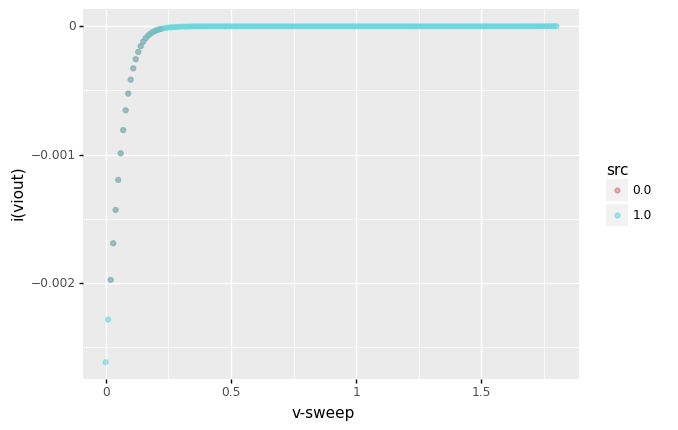

<ggplot: (8726338800797)>

In [27]:
(
    pn.ggplot(my_df.iloc[2:,], pn.aes(x="v-sweep",y="i(viout)", color="src"))
    + pn.geom_point(alpha=0.5)
)

In [3]:
LW_pairs = ([
    (0.25, 12), (0.5, 12), (3, 12),
    (0.25, 9), (0.5, 9), (3, 9),
    (0.25, 6), (0.5, 6), (3, 6),
    (0.25, 4), (0.5, 4), (3, 4),
    (0.25, 3), (0.5, 3), (3, 3),
    (0.25, 1), (0.5, 1), (3, 1),
])

In [75]:

df_tmp = pd.read_csv("schematic/data/dac7mc_L4W16vout-1.txt", delimiter="\s+")
percent80 = df_tmp[df_tmp["v-sweep"]==1.44]
percent0 = df_tmp[df_tmp["v-sweep"]==0]
(percent80["i(viout)"], percent0["i(viout)"])

(144    2.394935e-07
 Name: i(viout), dtype: float64,
 0    2.418845e-07
 Name: i(viout), dtype: float64)

In [80]:
((2.394935 - 2.418845)/2.418845)/1.44*100

-0.6864502134972224

In [29]:
LW_pairs = [(1,3)]#[(1, 4), (1, 3), (1,5), (3,12), (4, 12), (4, 16), (40, 16)]#[(4, 16)]#
L_list = []
W_list = []
per_list = []
for each in LW_pairs:
    L_list.append(each[0])
    W_list.append(each[1])
    my_df, my_per = import_vsweep(fpath="schematic/data/dac7my_L"+str(each[0])+"W"+str(each[1])+"vout-", num=2)
    per_list.append(my_per[0])
df_per = pd.DataFrame({
    "W": np.array(W_list),
    "L": np.array(L_list),
    "Per": np.array(per_list).flatten()
})

In [30]:
my_per

array([[-0.45614149],
       [-0.321083  ]])

In [36]:
per_list

[array([-1.02208154])]

In [31]:
%matplotlib inline

Text(0, 0.5, 'Variation (%)')

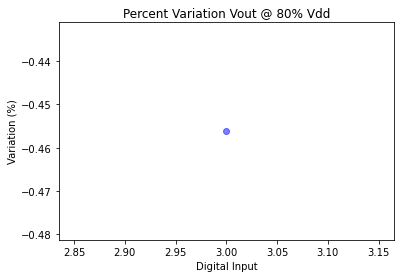

In [32]:
fig, ax = plt.subplots()
ax.plot(W_list, per_list, "bo", alpha=0.5)
ax.set_title("Percent Variation Vout @ 80% Vdd")
ax.set_xlabel("Digital Input")
ax.set_ylabel("Variation (%)")

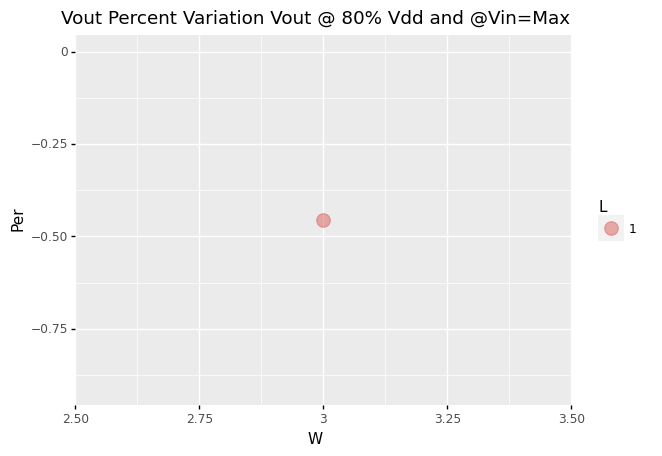

<ggplot: (8726338762048)>

In [33]:
df_per["L"] = df_per["L"].astype(str)
# df_per["W"] = df_per["W"].astype(str)
(
    pn.ggplot(df_per, pn.aes(x="W",y="Per", color="L"))
    + pn.geom_point(alpha=0.5, size=5)
    + pn.labs(
        title = "Vout Percent Variation Vout @ 80% Vdd and @Vin=Max"
    )
)

In [37]:
L_list = []
W_list = []
per_list = []
for each in LW_pairs:
    L_list.append(each[0])
    W_list.append(each[1])
    my_df, my_per = import_vsweep(fpath="schematic/data/dac7my_L"+str(each[0])+"W"+str(each[1])+"vout-", num=2)
    per_list.append(my_per[1])
df_per = pd.DataFrame({
    "W": np.array(W_list),
    "L": np.array(L_list),
    "Per": np.array(per_list).flatten()
})

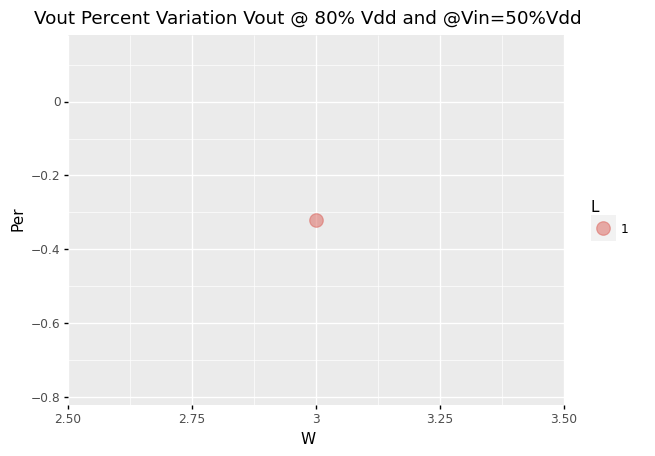

<ggplot: (8726338762219)>

In [38]:
df_per["L"] = df_per["L"].astype(str)
# df_per["W"] = df_per["W"].astype(str)
(
    pn.ggplot(df_per, pn.aes(x="W",y="Per", color="L"))
    + pn.geom_point(alpha=0.5, size=5)
    + pn.labs(
        title = "Vout Percent Variation Vout @ 80% Vdd and @Vin=50%Vdd"
    )
)

In [34]:
L_list = []
W_list = []
per_list = []
for each in LW_pairs:
    L_list.append(each[0])
    W_list.append(each[1])
    my_df, my_per = import_vsweep(fpath="schematic/data/dac7mc_L"+str(each[0])+"W"+str(each[1])+"vdd-", num=2)
    per_list.append(my_per[1])

df_per = pd.DataFrame({
    "W": np.array(W_list),
    "L": np.array(L_list),
    "Per": np.array(per_list).flatten()
})
df_per["L"] = df_per["L"].astype(str)
# df_per["W"] = df_per["W"].astype(str)
(
    pn.ggplot(df_per, pn.aes(x="W",y="Per", color="L"))
    + pn.geom_point(alpha=0.5, size=5)
    + pn.labs(
        title = "Vout Percent Variation Vout @ 80% Vdd and @Vout=50%Vdd"
    )
)

<ipython-input-2-9e5da8584970>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<ipython-input-2-9e5da8584970>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<ipython-input-34-ae81ae645a4a>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


TypeError: unhashable type: 'numpy.ndarray'